# Part 1 - Wordle Game

In [2]:
import pandas as pd
import numpy as np
import random
from termcolor import colored

## Codes to setup the game

In [3]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load files into dataframe
full_df = pd.read_csv('/content/drive/MyDrive/Wordle/Data/combined_wordlist.txt', sep=" ", header=None)
allowed_df = pd.read_csv('/content/drive/MyDrive/Wordle/Data/official_allowed_guesses.txt', sep=" ", header=None)
real_df = pd.read_csv('/content/drive/MyDrive/Wordle/Data/shuffled_real_wordles.txt', sep=" ", header=None)

In [5]:
# Convert dataframes into list
full_list = full_df[0].values.tolist()
allowed_list = allowed_df[0].values.tolist()
real_list = real_df[0].values.tolist()

# Global variables
# Use global because it's easier to update them rather than passing outputs around
global alphabet
global guess
global result

# Use escape word to quit game before attempts are used up
escape_word = 'gameover'

# Set random state
global_random_state = 1

In [6]:
# Set alphabet, which is displayed for available choices
def reset_alphabet():
    global alphabet
    alphabet = {'a': 'white', 'b': 'white', 'c': 'white', 'd': 'white', 'e': 'white', 'f': 'white', 'g': 'white',
                'h': 'white', 'i': 'white', 'j': 'white', 'k': 'white', 'l': 'white', 'm': 'white', 'n': 'white',
                'o': 'white', 'p': 'white', 'q': 'white', 'r': 'white', 's': 'white', 't': 'white',
                'u': 'white', 'v': 'white', 'w': 'white', 'x': 'white', 'y': 'white', 'z': 'white'}


# Ask for input
def ask_input():
    global guess
    
    while True:
        guess = input('Enter a 5 letters word: ').lower()

        # Secret escape word can be accepted
        if guess == escape_word:
            break
        # Only accept word within full_list
        elif guess not in full_list:
            print('Invalid input. ', end='')
        else:
            break


# Verify input and display result
def verify_input(answer, guess, output=False, printout=True):
    result = ['grey'] * 5                       # Initialize result

    answer_list = []                            # Initialize answer, to help deal with duplicate letters
    for n in answer:
        answer_list.append(n)

    for i in range(5):                          # First loop for green
        cur = guess[i]
        if cur == answer[i]:                    # If letter is a match
            result[i] = 'green'                 # Display this letter in result as green
            alphabet[cur] = 'green'             # Display this letter in alphabet as green
            answer_list.remove(cur)             # Remove this letter in answer_list, to remove duplicate for yellow check

    for i in range(5):                          # Second loop for yellow and grey
        cur = guess[i]
        if cur in (answer_list):                # If match with answer_list, which has matched letter removed
            if result[i] != 'green':            # Only update result to yellow, if it's not already green
                result[i] = 'yellow'
                answer_list.remove(cur)         # Similar to above, remove this letter in answer_list
            if alphabet[cur] != 'green':        # Only update alphabet to yellow, if it's not already green
                alphabet[cur] = 'yellow'
        if cur not in answer:                   # If no match with original answer
            alphabet[cur] = 'grey'              # Display this letter in alphabet as grey

    # Show guess result in color
    if printout:                                # Printout will be false during simulation
        for i in range(5):
            if result[i] in ('green', 'grey'):
                print(colored(guess[i], 'white', 'on_'+result[i], attrs=['bold']), end='')
            else:
                print(colored(guess[i], 'grey', 'on_'+result[i], attrs=['bold']), end='')
        print()

    # Show available letters of alphabet in color
    if printout:                                # Printout will be false during simulation
        print('Available letters: ', end='')
        for k, v in alphabet.items():
            if v in ('green', 'grey'):
                print(colored(k, 'white', 'on_'+v, attrs=['bold']), end='')
            else:
                print(colored(k, 'grey', 'on_'+v, attrs=['bold']), end='')
        print()

    # Return output in numeric format, which is used in solver
    if output:
        for i, n in enumerate(result):
            if n == 'grey':
                result[i] = 0
            elif n == 'yellow':
                result[i] = 1
            elif n == 'green': 
                result[i] = 2
        return result


# Play game with limited attempts
def wordle_game(max_try=6):
    answer = random.choice(real_list)           # Random word each game
    reset_alphabet()
    attempt = 0

    while attempt < max_try:
        print('Attempt ', attempt + 1, '/', max_try)
        ask_input()

        if guess == escape_word:                # If guess is secret escape word, end game with loss
            attempt = max_try
        else:
            verify_input(answer, guess)

            if guess != answer:
                attempt += 1
            else:
                print('You win!')
                attempt = max_try + 1
                break

    if attempt == max_try:
        print('You lost, the answer is \'', answer, '\'.')


## Play a game

In [ ]:
# Play game
wordle_game()

Attempt  1 / 6
Enter a 5 letters word: tares
tares
Available letters: abcdefghijklmnopqrstuvwxyz
Attempt  2 / 6
Enter a 5 letters word: shaky
shaky
Available letters: abcdefghijklmnopqrstuvwxyz
Attempt  3 / 6
Enter a 5 letters word: soars
soars
Available letters: abcdefghijklmnopqrstuvwxyz
Attempt  4 / 6
Enter a 5 letters word: solar
solar
Available letters: abcdefghijklmnopqrstuvwxyz
Attempt  5 / 6
Enter a 5 letters word: sonar
sonar
Available letters: abcdefghijklmnopqrstuvwxyz
You win!


# Part 2 - Wordle Solver using Information Gain
Provide suggestions solely on maximizing information gain

In [7]:
import itertools
import math
import csv
from tqdm import tqdm

## Codes to get information gain

In [8]:
# Create result_matrix
# It contains all possible combinations of guess results:
# grey - 0
# yellow - 1
# green - 2
result_matrix = list(itertools.product([0, 1, 2], repeat=5))
print(len(result_matrix))
print(result_matrix)

243
[(0, 0, 0, 0, 0), (0, 0, 0, 0, 1), (0, 0, 0, 0, 2), (0, 0, 0, 1, 0), (0, 0, 0, 1, 1), (0, 0, 0, 1, 2), (0, 0, 0, 2, 0), (0, 0, 0, 2, 1), (0, 0, 0, 2, 2), (0, 0, 1, 0, 0), (0, 0, 1, 0, 1), (0, 0, 1, 0, 2), (0, 0, 1, 1, 0), (0, 0, 1, 1, 1), (0, 0, 1, 1, 2), (0, 0, 1, 2, 0), (0, 0, 1, 2, 1), (0, 0, 1, 2, 2), (0, 0, 2, 0, 0), (0, 0, 2, 0, 1), (0, 0, 2, 0, 2), (0, 0, 2, 1, 0), (0, 0, 2, 1, 1), (0, 0, 2, 1, 2), (0, 0, 2, 2, 0), (0, 0, 2, 2, 1), (0, 0, 2, 2, 2), (0, 1, 0, 0, 0), (0, 1, 0, 0, 1), (0, 1, 0, 0, 2), (0, 1, 0, 1, 0), (0, 1, 0, 1, 1), (0, 1, 0, 1, 2), (0, 1, 0, 2, 0), (0, 1, 0, 2, 1), (0, 1, 0, 2, 2), (0, 1, 1, 0, 0), (0, 1, 1, 0, 1), (0, 1, 1, 0, 2), (0, 1, 1, 1, 0), (0, 1, 1, 1, 1), (0, 1, 1, 1, 2), (0, 1, 1, 2, 0), (0, 1, 1, 2, 1), (0, 1, 1, 2, 2), (0, 1, 2, 0, 0), (0, 1, 2, 0, 1), (0, 1, 2, 0, 2), (0, 1, 2, 1, 0), (0, 1, 2, 1, 1), (0, 1, 2, 1, 2), (0, 1, 2, 2, 0), (0, 1, 2, 2, 1), (0, 1, 2, 2, 2), (0, 2, 0, 0, 0), (0, 2, 0, 0, 1), (0, 2, 0, 0, 2), (0, 2, 0, 1, 0), (0, 2, 0,

In [9]:
# Get possible words based on green
def check_green(letter, position, current_possible):
    new_possible = []
    for word in current_possible:
        if letter == word[position]:
            new_possible.append(word)
            # Update remaining position
    return new_possible


# Get possible words based on yellow
# remaining_pos for yellow excludes green position, and current yellow position
def check_yellow(letter, position, remaining_pos, current_possible):
    new_possible = []
    for word in current_possible:
        if letter != word[position]:                                # No match on yellow's position
            for i in remaining_pos:                                 # Check all remaining position
                if letter == word[i]:                               # Look for match
                    new_possible.append(word)
    new_possible = list(set(new_possible))                          # Convert to set then back to list to only keep unique
    return new_possible


# Get possible words based on grey
# remaining_pos for grey excludes green position; if a letter alread appeared, remaining_pos = position
def check_grey(letter, position, remaining_pos, current_possible):
    new_possible = []
    for word in current_possible:
        keep = True                                                 # Set keep to True, assuming we keep this word
        for i in remaining_pos:
            if letter == word[i]:                                   # If a letter is matched in remaining position
                keep = False                                        # Set keep to False
        if keep == True:                                            # Only add to list if keep is True
            new_possible.append(word)
    return new_possible


# Combine the 3 functions from above
# Get possible words based on result
def get_possible_words(guess, result, current_possible):
    new_possible = current_possible
    remaining_pos = list(range(5))
    appeared_yellow = []

    # Green
    for i in range(5):
        if result[i] == 2:
            new_possible = check_green(guess[i], i, new_possible)
            remaining_pos.remove(i)

    # Yellow
    for i in range(5):
        if result[i] == 1:
            temp_remaining_pos = [x for x in remaining_pos if x != i]                           # Need to ignore current yellow from remaining_pos
            new_possible = check_yellow(guess[i], i, temp_remaining_pos, new_possible)
            appeared_yellow.append(guess[i])

    # Grey
    for i in range(5):
        if result[i] == 0:
            if guess[i] in appeared_yellow:                                                     # If a letter is grey but already appeared as yellow, it just means it's not appearing at its current position
                new_possible = check_grey(guess[i], i, [i], new_possible)                       # So only check it on its exact positions
            else:
                new_possible = check_grey(guess[i], i, remaining_pos, new_possible)

    return new_possible

In [10]:
# Measure a word with result_matrix, show all details
# Note, this isn't used in wordle_solver, but it helps explain how information gain is calculated
def measure_guess_gain_detail(guess, current_possible):
    word_list = []
    result_list = []
    possible_count_list = []
    removed_count_list = []
    probability_list = []
    gain_list = []

    for result in result_matrix:
        word_list.append(guess)
        result_list.append(result)

        possible_word = get_possible_words(guess, result, current_possible)

        possible_count_list.append(len(possible_word))

        removed = len(current_possible) - len(possible_word)
        removed_count_list.append(removed)

        probability = len(possible_word) / len(current_possible)
        probability_list.append(probability)

        # Gain is calculated using probability of this result * information gain of using this result
        if probability != 0:
            gain_list.append(probability * math.log2(1/probability))
        else: gain_list.append(0)

    output_df = pd.DataFrame({
        'Guess': word_list,
        'Result': result_list,
        'Possible Count': possible_count_list,
        'Removed Count': removed_count_list,
        'Result Possibility': probability_list,
        'Information Gain': gain_list
    })


    return output_df

In [11]:
# Look at detail of gain for a word
pd.set_option('display.width', 150)
print(measure_guess_gain_detail('shake', full_list))
print(measure_guess_gain_detail('shake', full_list)['Information Gain'].sum())

     Guess           Result  Possible Count  Removed Count  Result Possibility  Information Gain
0    shake  (0, 0, 0, 0, 0)            1197          11775            0.092276          0.317235
1    shake  (0, 0, 0, 0, 1)            1213          11759            0.093509          0.319684
2    shake  (0, 0, 0, 0, 2)             591          12381            0.045560          0.203018
3    shake  (0, 0, 0, 1, 0)             100          12872            0.007709          0.054111
4    shake  (0, 0, 0, 1, 1)             118          12854            0.009097          0.061679
..     ...              ...             ...            ...                 ...               ...
238  shake  (2, 2, 2, 1, 1)               0          12972            0.000000          0.000000
239  shake  (2, 2, 2, 1, 2)               0          12972            0.000000          0.000000
240  shake  (2, 2, 2, 2, 0)               3          12969            0.000231          0.002793
241  shake  (2, 2, 2, 2, 1)   

In [12]:
# Measure a word with result_matrix, just show information gain
def measure_guess_gain(guess, current_possible):
    total_IG = 0

    for result in result_matrix:
        possible_word = get_possible_words(guess, result, current_possible)

        probability = len(possible_word) / len(current_possible)

        # Gain is calculated using probability of this result * information gain
        if probability != 0:
            total_IG += probability * math.log2(1/probability)

    return total_IG

In [13]:
# Look at information gain for a word
print(measure_guess_gain('shake', full_list))

5.181402661818071


## Generate recommendation for 1st guess
- Only need to run these codes onces
- In the future, just load the csv or pick a word from result
- This is to save time

In [ ]:
# These codes only need to be ran once, because the output is saved into a CSV
"""
with open('1st_guess_info_gain.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for word in tqdm(full_list):
        word_gain = measure_guess_gain(word, full_list)
        writer.writerow([word, word_gain])
"""

100%|██████████| 12972/12972 [1:51:05<00:00,  1.95it/s]


In [14]:
# Load guess information gain file
guess1_gain_df = pd.read_csv('/content/drive/MyDrive/Wordle/Data/1st_guess_info_gain.csv')

# Load files into dataframe, if uploaded manually
# guess1_gain_df = pd.read_csv('1st_guess_info_gain.csv')

# Rename "Score" into "IG Score" (Information Gain Score)
guess1_gain_df = guess1_gain_df.rename(columns={"Score": "IG Score"})

# Get top 10 list
top10_guess1_df = guess1_gain_df.sort_values(by='IG Score', ascending=False)[0:10]
top10_guess1_df

,Word,IG Score
103,tares,6.194053
9267,lares,6.149919
6646,rales,6.114343
1202,rates,6.096243
7529,teras,6.076619
6625,nares,6.066831
12250,soare,6.061395
9592,tales,6.054988
11871,reais,6.049778
783,tears,6.032339


## Codes to run Wordle Solver

In [15]:
# Measure information gain for all possible guesses
def measure_guess_gain_list(guess_list, current_possible):
    word_list = []
    gain_list = []

    for word in tqdm(guess_list):                                                               # This part takes awhile, so show a progress bar
        word_list.append(word)
        gain_list.append(measure_guess_gain(word, current_possible))

    output_df = pd.DataFrame({
        'Word': word_list,
        'Score': gain_list
    })

    output_df = output_df.sort_values(by='Score', ascending=False)

    return output_df


# Ask for input
def ask_input_solver(status):
    while True:
        global guess
        global result

        if status == 'guess':
            message = 'Which word did you guess? '

            guess = input(message).lower()
        
            # Secret escape word can be accepted
            if guess == escape_word:
                break
            # Only accept word within full_list
            elif guess not in full_list:
                print('Invalid input. ', end='')
            else:
                break

        elif status == 'result':
            message = 'What is the result? '

            result = input(message)
            if result == escape_word:
                guess = escape_word
                break
            else:
                try:
                    result = tuple([int(a) for a in str(result)])           # Wrap input result in a tuple, to match result_matrix
                    if result not in result_matrix:                         # If input result is not within result matrix
                        print('Invalid input. ', end='')
                    else:
                        break
                except:
                    print('Invalid input. ', end='')


# Solve a game with limited attempts
def wordle_solver(max_try=6):
    attempt = 0
    prev_possible = full_list

    print('Top 10 recommended 1st guess:')
    print(top10_guess1_df.to_string(index=False))

    while attempt < max_try:
        print('Attempt ', attempt + 1, '/', max_try)

        ask_input_solver('guess')
        if guess == escape_word:                # If guess is secret escape word, end session
            attempt = max_try
            break
        
        ask_input_solver('result')
        if result == escape_word:               # If result is secret escape word, end session
            attempt = max_try
            break

        if result == (2, 2, 2, 2, 2):
            print('You won!')
            attempt = max_try + 1
            break
        else:
            curr_possible = get_possible_words(guess, result, prev_possible)
            curr_gain = measure_guess_gain_list(curr_possible, curr_possible)
            
            print('# of words remaining', len(curr_possible))
            print('Top 10 recommended guess:')
            print(curr_gain[0:10].to_string(index=False))
            print('-' * 30)

            # Prepare for next loop
            prev_possible = curr_possible
            attempt += 1

    if attempt >= max_try:
        print('Game Over')

## Solve a game

When prompted to enter result, use numbers to represent color.

- 0 = Grey

- 1 = Yellow

- 2 = Green


For example, the word below would be 20010.

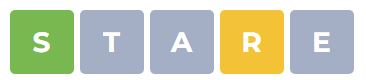

In [37]:
# Result color code: Grey=0, Yellow=1, Green=2
# Example: 01002, if second letter is yellow and last letter is green
wordle_solver()

Top 10 recommended 1st guess:
 Word  IG Score
tares  6.194053
lares  6.149919
rales  6.114343
rates  6.096243
teras  6.076619
nares  6.066831
soare  6.061395
tales  6.054988
reais  6.049778
tears  6.032339
Attempt  1 / 6
Which word did you guess? tares
What is the result? 10011


100%|██████████| 96/96 [00:00<00:00, 138.74it/s]


# of words remaining 96
Top 10 recommended guess:
 Word    Score
sente 6.106118
stept 6.083382
stent 5.843787
suete 5.695349
styte 5.600700
steme 5.082155
stele 5.081460
stede 5.014712
geste 4.963633
egest 4.667513
------------------------------
Attempt  2 / 6
Which word did you guess? sente
What is the result? 12020


100%|██████████| 8/8 [00:00<00:00, 290.97it/s]


# of words remaining 8
Top 10 recommended guess:
 Word    Score
pesty 1.811278
pesto 1.548795
yesty 1.405639
festy 1.405639
zesty 1.405639
besti 1.061278
mesto 1.061278
cesti 1.061278
------------------------------
Attempt  3 / 6
Which word did you guess? pesty
What is the result? 02222


100%|██████████| 3/3 [00:00<00:00, 292.10it/s]


# of words remaining 3
Top 10 recommended guess:
 Word    Score
yesty 0.918296
festy 0.918296
zesty 0.918296
------------------------------
Attempt  4 / 6
Which word did you guess? yesty
What is the result? 02222


100%|██████████| 2/2 [00:00<00:00, 311.38it/s]


# of words remaining 2
Top 10 recommended guess:
 Word  Score
festy    1.0
zesty    1.0
------------------------------
Attempt  5 / 6
Which word did you guess? festy
What is the result? 02222


100%|██████████| 1/1 [00:00<00:00, 286.36it/s]


# of words remaining 1
Top 10 recommended guess:
 Word  Score
zesty    0.0
------------------------------
Attempt  6 / 6
Which word did you guess? zesty
What is the result? 22222
You won!
Game Over


# Part 3 - Wordle Solver with Machine Learning Added

## Cleaning and Feature Engineering

Create ML_df which is full list of words with extra details used for ML

In [16]:
# Create ML_df
ML_df = full_df.copy()
ML_df.columns = ['word']                                     # Add header so it can be joined (merged) on this column
print(ML_df.shape)
ML_df.head()

(12972, 1)


,word
0,noles
1,melas
2,waist
3,ohias
4,mummy


### Add a column for Answer

- This will be a boolean showing whether the word was used as answer before
- This column will be used as output(y) in ML models

In [17]:
# Update answer column on ML_df, showing if the word was used as answer
answer_check = ML_df['word'].isin(real_list)
ML_df['answer'] = answer_check.astype(int)                      # Convert bool to int

# Double check that we have the correct number of answer set to 1 or True
print(len(real_list))
print(sum(ML_df['answer']))

print(ML_df.shape)
ML_df.head()

2315
2315
(12972, 2)


,word,answer
0,noles,0
1,melas,0
2,waist,1
3,ohias,0
4,mummy,1


### Add a column for Word Frequency

- This column uses the number of count for this word as frequency
- Source: https://www.kaggle.com/rtatman/english-word-frequency?select=unigram_freq.csv
- This column will be used as one of the inputs(X) in the ML models

In [18]:
from sklearn import preprocessing

# Load word frequency file
freq_df = pd.read_csv('/content/drive/MyDrive/Wordle/Data/unigram_freq.csv')
print(freq_df.shape)

# Only keep words in wordle full list
freq_wordle_df = freq_df.loc[freq_df['word'].isin(full_list)]
print(freq_wordle_df.shape)

# Add new column to ML_df, showing frequency
ML_df = pd.merge(ML_df, freq_wordle_df, on='word', how='left')
ML_df['count'] = ML_df['count'].fillna(0)                     # Replace NaN with 0

# Add new column to ML_df, showing normalized frequency
count_norm = preprocessing.normalize([ML_df['count']])
ML_df['count_norm'] = count_norm[0]

print(ML_df.shape)
ML_df.head()

(333333, 2)
(8092, 2)
(12972, 4)


,word,answer,count,count_norm
0,noles,0,55380.0,0.000015
1,melas,0,64255.0,0.000018
2,waist,1,5013500.0,0.001391
3,ohias,0,0.0,0.000000
4,mummy,1,1878933.0,0.000521


### Add a column for Base Form

- This will be a boolean showing if the word is in its base form
- I hypothesized that plural forms and past tense words will less likely be picked as answer
- If this is confirmed, then the number of likely guesses can be reduced
- This column will be used as one of the inputs(X) in the ML models

In [19]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# Save the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

# Create list of lemmatized singular words (for noun) from full_list
singular_words = []
for word in full_list:
    if word == wordnet_lemmatizer.lemmatize(word, 'n'):
        singular_words.append(word)

# Create list of lemmatized present tense words (for verb) from full_list
present_words = []
for word in full_list:
    if word == wordnet_lemmatizer.lemmatize(word, 'v'):
        present_words.append(word)

# Add new column to ML_df, showing if the word is in singular form (for noun)
singular_check = ML_df['word'].isin(singular_words)
ML_df['singular'] = singular_check.astype(int)                        # Convert bool to int

# Add new column to ML_df, showing if the word is in present form (for verb)
present_check = ML_df['word'].isin(present_words)
ML_df['present'] = present_check.astype(int)                          # Convert bool to int

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [20]:
# Look at a few words to check if result is right
print(ML_df[ML_df['word'] == 'cigar'].to_string())
print()
print(ML_df[ML_df['word'] == 'plush'].to_string())
print()
print(ML_df[ML_df['word'] == 'meals'].to_string())              # Plural
print()
print(ML_df[ML_df['word'] == 'words'].to_string())              # Plural
print()
print(ML_df[ML_df['word'] == 'acted'].to_string())              # Past tense
print()
print(ML_df[ML_df['word'] == 'boxed'].to_string())              # Past tense
print()

print('Count of False')
print(len(ML_df[ML_df['singular'] == 0]))
print(len(ML_df[ML_df['present'] == 0]))

      word  answer      count  count_norm  singular  present
615  cigar       1  3993843.0    0.001108         1        1

        word  answer      count  count_norm  singular  present
11739  plush       1  4692870.0    0.001302         1        1

       word  answer       count  count_norm  singular  present
3331  meals       0  11515834.0    0.003195         0        1

       word  answer       count  count_norm  singular  present
4429  words       0  90910143.0    0.025222         0        0

       word  answer      count  count_norm  singular  present
1670  acted       0  4468180.0     0.00124         1        0

     word  answer      count  count_norm  singular  present
31  boxed       0  5778226.0    0.001603         1        0

Count of False
2041
1413


### Add a column for Name

- This will be a boolean showing if the word is in a name
- Source: https://github.com/smashew/NameDatabases/blob/master/NamesDatabases/first%20names/us.txt
- I hypothesized that words that are common names are less likely be picked as answer (this is actually false, which will be shown later)
- If this is confirmed, then the number of likely guesses can be reduced
- This column will be used as one of the inputs(X) in the ML models

In [21]:
# Load name file
name_df = pd.read_csv('/content/drive/MyDrive/Wordle/Data/common_names.txt', header=None)

# Get list of names
name_list = name_df[0]

# Convert to lower case
name_list = list(map(lambda x: x.lower(), name_list))

# Only keep words in wordle full list
name_wordle_list = [w for w in name_list if w in full_list]

# Add new column to ML_df, showing if the word is in a name
name_check = ML_df['word'].isin(name_wordle_list)
ML_df['name'] = name_check.astype(int)                          # Convert bool to int

# Look at a few words to check if result is right
print(ML_df[ML_df['word'] == 'billy'].to_string())
print()
print(ML_df[ML_df['word'] == 'nancy'].to_string())
print()
print(ML_df[ML_df['word'] == 'jacky'].to_string())              # This name database doesn't have Jacky for some reason
print()
print(ML_df[ML_df['word'] == 'price'].to_string())
print()

       word  answer       count  count_norm  singular  present  name
5840  billy       1  13515249.0     0.00375         1        1     1

       word  answer       count  count_norm  singular  present  name
5152  nancy       0  13381057.0    0.003712         1        1     1

       word  answer     count  count_norm  singular  present  name
6181  jacky       0  395853.0     0.00011         1        1     0

      word  answer        count  count_norm  singular  present  name
407  price       1  501651226.0     0.13918         1        1     0



In [22]:
# Count of words that are answer and name
print('A:1, N:1')
print(ML_df[(ML_df['answer'] == 1) & (ML_df['name'] == 1)].shape[0])
print()

# Count of words that are not answer and name
print('A:0, N:1')
print(ML_df[(ML_df['answer'] == 0) & (ML_df['name'] == 1)].shape[0])
print()

# Count of words that are answer and not name
print('A:1, N:0')
print(ML_df[(ML_df['answer'] == 1) & (ML_df['name'] == 0)].shape[0])
print()

# Count of words that are not answer and not name
print('A:0, N:0')
print(ML_df[(ML_df['answer'] == 0) & (ML_df['name'] == 0)].shape[0])

A:1, N:1
86

A:0, N:1
145

A:1, N:0
2229

A:0, N:0
10512


## Feature selection

In [23]:
# Group by answer
ML_df.groupby(by='answer').mean().round(4)

,count,count_norm,singular,present,name
answer,,,,,
0,1.469030e+06,0.0004,0.8090,0.8764,0.0136
1,2.056245e+07,0.0057,0.9974,0.9585,0.0371


Words that are answer:

- tend to have a higher count
- are much more likely to be in base form (singular and present)
- are slightly more likely to be name

count_norm: 0.6888221590935226
  singular: 0.27190044077738834
   present: 0.021256852495654607
      name: 0.01802054763343459


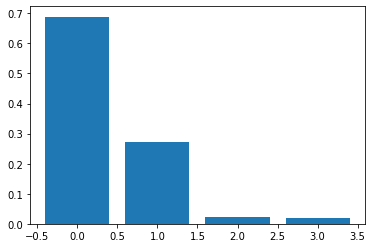

In [24]:
# Decision tree for feature importance on a regression problem
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot

# Define dataset
y = ML_df[['answer']]
X = ML_df[['count_norm', 'singular', 'present', 'name']]

# Define the model (give it max depth of 5, which is one more than features of X)
model = DecisionTreeRegressor(max_depth=5, random_state=global_random_state)

# Fit the model
model.fit(X, y)

# Get importance
importance = model.feature_importances_

# Summarize feature importance
"""
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
"""

print('count_norm:', importance[0])
print('  singular:', importance[1])
print('   present:', importance[2])
print('      name:', importance[3])

# Plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In conclusion, seems like name is not a good predictor (at least with current setup). It is also shown that my hypothesis about name less likely to be answer is false.

This is verified by just looking at the mean, as well as using decision tree regressor to check feature importance.

So name column will not be selected as input feature for ML models in later sections.

Whether a word is in present tense is also not a useful predictor (surprisingly).

Reference: https://machinelearningmastery.com/calculate-feature-importance-with-python/

## ML

In [25]:
from sklearn.feature_selection import RFECV
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import cross_val_score
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn import metrics

import warnings

### Train Test Split

In [26]:
# Load Wordle answers listed in order; this dataset differs from real_list, because real_list is in random order
answer_ordered_df = pd.read_csv('/content/drive/MyDrive/Wordle/Data/Wordle Answers.csv')

# Only take 1st 300 words, as currently these answers are known
answer_ordered_df = answer_ordered_df[0:300]

# Convert into list
answer_list = answer_ordered_df['Word'].values.tolist()

# Check
print(len(answer_list))
print(answer_list[0:5])
print()

# Add new column to ML_df, marking these 300 answers as ones we want to keep for model
in_model_check = ML_df['word'].isin(answer_list)
ML_df['in_model'] = in_model_check.astype(int)                  # Convert bool to int

# Look at a few words to check if result is right
print(ML_df[ML_df['word'] == 'cigar'].to_string())
print()
print(ML_df[ML_df['word'] == 'awake'].to_string())
print()
print(ML_df[ML_df['word'] == 'heist'].to_string())              # This word is an answer, but it is for a later date, so it should have in_model == 0
print()
print(ML_df[ML_df['word'] == 'ovolo'].to_string())              # Not an answer and not in model

300
['cigar', 'rebut', 'sissy', 'humph', 'awake']

      word  answer      count  count_norm  singular  present  name  in_model
615  cigar       1  3993843.0    0.001108         1        1     0         1

       word  answer      count  count_norm  singular  present  name  in_model
7427  awake       1  3230337.0    0.000896         1        1     0         1

        word  answer     count  count_norm  singular  present  name  in_model
10442  heist       1  419629.0    0.000116         1        1     0         0

       word  answer  count  count_norm  singular  present  name  in_model
9639  ovolo       0    0.0         0.0         1        1     0         0


In [27]:
# Find ratio of answer and full list
print('  Full list:', len(full_list))
print('Answer list:', len(real_list))

ratio = len(full_list) / len(real_list)
print('Ratio:', ratio)

# Maintain the ratio in our sample selection
# Since there is only 300 words as known answers, use 300 * 5.6 = 1680 as total sample size

# Extract 300 entries where word was used as answer, which we marked as in_model
ML_300_df = ML_df[ML_df['in_model'] == 1]
print('ML_300_df:', ML_300_df.shape)

# Extract 1380 entries where word was not used as answer
ML_1380_df = ML_df[ML_df['answer'] == 0].sample(n=1380, random_state=1)
print('ML_1380_df:', ML_1380_df.shape)

# Combine above 2 dataframes, and create the whole set of 1680 words used to run ML model
ML_1680_df = pd.concat([ML_300_df, ML_1380_df])
print('ML_1680_df:', ML_1680_df.shape)

  Full list: 12972
Answer list: 2315
Ratio: 5.603455723542116
ML_300_df: (300, 8)
ML_1380_df: (1380, 8)
ML_1680_df: (1680, 8)


In [28]:
# Train test split
# Note, name is not selected as feature
features = ['count_norm', 'singular', 'present']

y = ML_1680_df['answer']
X = ML_1680_df[features]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=global_random_state)

print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

X_train.head()

(1512, 3)
(168, 3)
(1512,)
(168,)


,count_norm,singular,present
34,0.000000,1,1
4379,0.000000,1,1
12910,0.000027,1,0
12847,0.000000,1,1
11459,0.000000,1,1



### Model Selection

- Quickly apply multiple ML algorithms, and evaluate which performs better
- Codes are from: https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
- However, I made some adjustments of my own


In [164]:
"""
# These codes only need to be ran once
"""

# Both F1_score and Recall have merits to be the scoring method
# F1 score helps find a balanced result
# Recall is also good, because the point is to get as many positives as possible and false positive can be tolerated
score_method = 'f1_micro'
# score_method = 'recall'

# Turn off warnings (most warnings are about models not converging)
# Reset warnings at the end of this block
warnings.filterwarnings("ignore")

# Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    # Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    # Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),

    # GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),

    # Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),

    # Nearest Neighbor
    neighbors.KNeighborsClassifier(),

    # SVM
    svm.SVC(probability=True),
    # svm.NuSVC(probability=True),                                  # This is skipped because it runs into issues
    svm.LinearSVC(),

    # Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    # Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis()
]

# Split dataset in cross-validation with this splitter class
# Note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=.2, train_size=.7, random_state=global_random_state)
# Run model 10x with 70/20 split intentionally leaving out 10%

# Create table to compare MLA metrics
MLA_columns = ['[MLA Name]',
               '[MLA Parameters]',
               '[MLA Train Score Mean]',
               '[MLA Test Score Mean]',
               '[MLA Test Score Mean Minus 3*STD]',
               '[MLA Time]']
MLA_compare = pd.DataFrame(columns=MLA_columns)

# Create table to compare MLA predictions
MLA_predict = y

# Index through MLA and save performance to table
row_index = 0
for alg in MLA:
    # Set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, '[MLA Name]'] = MLA_name
    MLA_compare.loc[row_index, '[MLA Parameters]'] = str(alg.get_params())

    # Score model with cross validation
    cv_results = model_selection.cross_validate(alg, X, y, scoring=score_method, cv=cv_split, return_train_score=True)

    MLA_compare.loc[row_index, '[MLA Train Score Mean]'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, '[MLA Test Score Mean]'] = cv_results['test_score'].mean()

    # If this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    # Let's know the worst that can happen!
    MLA_compare.loc[row_index, '[MLA Test Score Mean Minus 3*STD]'] = cv_results['test_score'].mean() - cv_results['test_score'].std() * 3

    MLA_compare.loc[row_index, '[MLA Time]'] = cv_results['fit_time'].mean()

    # Save MLA predictions
    alg.fit(X, y)
    MLA_predict[MLA_name] = alg.predict(X)

    y = ML_1680_df['answer']      # Some models changed Y, so it is refreshed here

    row_index += 1

# Reset warnings
warnings.resetwarnings()

In [165]:
"""
# These codes only need to be ran once
"""

# Print and sort table
MLA_compare.sort_values(by=['[MLA Test Score Mean]'], ascending=False, inplace=True)
with pd.option_context('display.max_columns', None, 'display.max_colwidth', 20):
    print(MLA_compare)
print('-' * 30)

             [MLA Name]     [MLA Parameters] [MLA Train Score Mean] [MLA Test Score Mean] [MLA Test Score Mean Minus 3*STD] [MLA Time]
0    AdaBoostClassifier  {'algorithm': 'S...             0.930442               0.916667              0.885996                0.283555
3   GradientBoosting...  {'ccp_alpha': 0....             0.948129               0.915774               0.88432                0.111878
13  KNeighborsClassi...  {'algorithm': 'a...             0.932568               0.911607              0.876786                0.003415
1     BaggingClassifier  {'base_estimator...             0.980187               0.894643              0.858884                0.034542
4   RandomForestClas...  {'bootstrap': Tr...             0.989626               0.893452               0.84675                0.199876
17  ExtraTreeClassifier  {'ccp_alpha': 0....             0.991327               0.891369              0.846326                0.003311
2   ExtraTreesClassi...  {'bootstrap': Fa...           

### Adaptive Boost Classifier (on Decision Tree)

- In terms of F1 score, best performing model is AdaBoostClassifier, bosting on decision tree
- But it's recall is not high

In [45]:
"""
# These codes only need to be ran once
"""

# Hyper-parameter search using GridSearchCV
parameters = {'base_estimator': [tree.DecisionTreeClassifier(max_depth=2, random_state=global_random_state),
                                 tree.DecisionTreeClassifier(max_depth=3, random_state=global_random_state),
                                 tree.DecisionTreeClassifier(max_depth=4, random_state=global_random_state),
                                 tree.DecisionTreeClassifier(max_depth=5, random_state=global_random_state)],
              'n_estimators': list(range(10, 60, 10)),
              'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
              'random_state': [global_random_state]}
# Note: models such as rf_model and gb_model could be added into base_estimator

ab_gridSearch = GridSearchCV(ensemble.AdaBoostClassifier(),
                             parameters,
                             cv=5,
                             scoring='f1_micro')
ab_gridSearch.fit(X_train, y_train)
print("<<Adaptive Boost>>")
print(ab_gridSearch.best_params_)

<<Adaptive Boost>>
{'base_estimator': DecisionTreeClassifier(max_depth=2, random_state=1), 'learning_rate': 0.05, 'n_estimators': 40, 'random_state': 1}


In [29]:
# Build model using best_estimator_ from Grid Search
# Uncomment and use the line below if block above was ran
# ab_model = ab_gridSearch.best_estimator_

# ------------------------------------------------------------------------------

# Build model by manually inputting the best_estimator parameters
# {'base_estimator': DecisionTreeClassifier(max_depth=2, random_state=1), 'learning_rate': 0.05, 'n_estimators': 40, 'random_state': 1}
dc_model = tree.DecisionTreeClassifier(max_depth=2, random_state=global_random_state)
ab_model = ensemble.AdaBoostClassifier(base_estimator=dc_model, learning_rate=0.05, n_estimators=40, random_state=global_random_state)

ab_model.fit(X_train, y_train)
y_train_pred = ab_model.predict(X_train)
y_valid_pred = ab_model.predict(X_valid)

# Evaluate model using prediction on training and validation set
train_score = {'Accuracy': metrics.accuracy_score(y_train, y_train_pred),
               'F1 Score': metrics.f1_score(y_train, y_train_pred),
               'Precision': metrics.precision_score(y_train, y_train_pred),
               'Recall': metrics.recall_score(y_train, y_train_pred),
               'AUC Score': metrics.roc_auc_score(y_train, y_train_pred)}
validation_score = {'Accuracy': metrics.accuracy_score(y_valid, y_valid_pred),
                    'F1 Score': metrics.f1_score(y_valid, y_valid_pred),
                    'Precision': metrics.precision_score(y_valid, y_valid_pred),
                    'Recall': metrics.recall_score(y_valid, y_valid_pred),
                    'AUC Score': metrics.roc_auc_score(y_valid, y_valid_pred)}

ab_result = pd.DataFrame({'Training Data': train_score, 'Validation Data': validation_score})
print(ab_result)

           Training Data  Validation Data
Accuracy        0.925926         0.928571
F1 Score        0.780392         0.818182
Precision       0.815574         0.843750
Recall          0.748120         0.794118
AUC Score       0.856002         0.878402


### Evaluate Model

- Now the true test, predict the whole dataset and see if it does well
- View the wrong predictions in test set, so we can get some insights on which word it gets wrong
- This may appear as "cheating", since we are looking at all the answers for Wordle game in the future, but this is only for evaluation
- The ML model doesn't use this data, so the model itself is still honest and doesn't overfit

In [30]:
pred = ab_model.predict(ML_df[features])

pred_result_df = ML_df.copy()
pred_result_df['pred'] = pred                                               # Add pred_proba as a column

print('Confusion Matrix')
conf_matrix = pd.DataFrame(metrics.confusion_matrix(ML_df['answer'], pred), 
                           index=['answer:False', 'answer:True'],
                           columns=['pred:False', 'pred:True'])
print(conf_matrix)
print()

print('Accuracy')
print(metrics.accuracy_score(ML_df['answer'], pred))
print()

print('F1 Score')
print(metrics.f1_score(ML_df['answer'], pred))
print()

print('Precision')
print(metrics.precision_score(ML_df['answer'], pred))
print()

print('Recall')
print(metrics.recall_score(ML_df['answer'], pred))
print()

print('Wrong Predictions')
pred_result_df[pred_result_df['pred'] != pred_result_df['answer']]

Confusion Matrix
              pred:False  pred:True
answer:False       10116        541
answer:True          684       1631

Accuracy
0.9055658341042245

F1 Score
0.7269890795631826

Precision
0.7509208103130756

Recall
0.7045356371490281

Wrong Predictions


,word,answer,count,count_norm,singular,present,name,in_model,pred
31,boxed,0,5778226.0,0.001603,1,0,0,0,1
64,yahoo,0,155733641.0,0.043207,1,1,0,0,1
66,annul,1,146490.0,0.000041,1,1,0,0,0
72,gamut,1,553397.0,0.000154,1,1,0,0,0
86,auger,0,678597.0,0.000188,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...
12883,alder,0,972850.0,0.000270,1,1,0,0,1
12899,foist,1,55908.0,0.000016,1,1,0,0,0
12912,rhine,0,1162642.0,0.000323,1,1,0,0,1
12959,bough,1,520067.0,0.000144,1,1,0,0,0


Use predict_proba's second number, to get probability of predictiong 'answer' (1)

predict_proba shows two classes, 0 and 1 in this case

We just need 1's probability, so add this at the end: [:, 1]

In [31]:
# Insert pred into pred_result_df
pred_proba = ab_model.predict_proba(ML_df[features])[:, 1]

pred_result_df['pred'] = pred_proba                                         # Replace pred with pred_proba

pred_result_df.head()

,word,answer,count,count_norm,singular,present,name,in_model,pred
0,noles,0,55380.0,0.000015,1,1,0,0,0.091216
1,melas,0,64255.0,0.000018,1,1,0,0,0.247166
2,waist,1,5013500.0,0.001391,1,1,0,0,0.679636
3,ohias,0,0.0,0.000000,1,1,0,0,0.065579
4,mummy,1,1878933.0,0.000521,1,1,0,0,0.589212


If there is a large amount of False Negative or False Positive. The threshold for positive prediction can be changed.

However, since I will be using pred_prod instead of actual prediction, this can be skipped.

In [32]:
# If threshold does need to be adjusted, change the number here to find optimal number of predictions
print(pred_result_df[pred_result_df['pred'] > 0.42].shape)

# Count of words that has low ML Score
print(pred_result_df[pred_result_df['pred'] <= 0.02].shape[0])

# Count of words that are answer but has low ML Score
print(pred_result_df[(ML_df['answer'] == 1) & (pred_result_df['pred'] <= 0.02)].shape[0])

pred_result_df[pred_result_df['pred'] <= 0.02].head()

(3111, 9)
594
2


,word,answer,count,count_norm,singular,present,name,in_model,pred
23,safes,0,1079012.0,0.000299,0,1,0,0,0.013877
24,mites,0,798205.0,0.000221,0,1,0,0,0.013605
51,bases,0,8663363.0,0.002404,0,0,0,0,0.011853
55,reefs,0,1553553.0,0.000431,0,0,0,0,0.008045
90,crops,0,7931319.0,0.002200,0,0,0,0,0.011853


## Update 1st guess recommendations

Combine the IG Score and ML Score by multiplying them.

In [33]:
# Update guess1_gain_df with pred column
guess1_gain_df = pd.read_csv('/content/drive/MyDrive/Wordle/Data/1st_guess_info_gain.csv')

# Rename "Score" into "IG Score" (Information Gain Score)
guess1_gain_df = guess1_gain_df.rename(columns={"Score": "IG Score"})

# Add prediction probability as "ML Score" (Machine Learning Score)
guess1_gain_df['ML Score'] = pred_result_df['pred']

# Add Total Score that is sum of IG Score and ML Score
guess1_gain_df['Total Score'] = guess1_gain_df['IG Score'] * guess1_gain_df['ML Score']

# Round to 4th decimal place
guess1_gain_df = guess1_gain_df.round(4)

# Get top 10 list
top10_guess1_df = guess1_gain_df.sort_values(by='Total Score', ascending=False)[0:10]
top10_guess1_df

,Word,IG Score,ML Score,Total Score
5459,least,5.6792,0.7577,4.3033
2846,store,5.6762,0.7577,4.3010
9725,paris,5.6687,0.7577,4.2954
11667,saint,5.6546,0.7577,4.2847
9942,share,5.6414,0.7577,4.2747
9959,later,5.6061,0.7577,4.2479
89,suite,5.5646,0.7577,4.2164
3104,scale,5.5554,0.7577,4.2095
6623,stone,5.5281,0.7577,4.1888
10690,learn,5.4821,0.7577,4.1539


## Update Wordle Solver

In [34]:
# Look up a word in ML's pred_result_df, and return its score
def get_ML_score(guess):
    ML_score = pred_result_df[pred_result_df['word'] == guess]['pred']
    return ML_score.values[0]


# Update measure_guess_gain_list
# - Two input methods: Total Score and IG Score
# - Printout toggle
def measure_guess_gain_list(guess_list, current_possible, scoring=['Total Score', 'IG Score'], printout=True):
    word_list = []
    gain_score_list = []
    ML_score_list = []
    total_score_list = []

    if printout:                                                    # Show a progress bar using tqdm if printout is True
        for word in tqdm(guess_list):                                                               
            word_list.append(word)

            gain_score = measure_guess_gain(word, current_possible)
            gain_score_list.append(gain_score)
            
            ML_score = get_ML_score(word)
            ML_score_list.append(ML_score)

            total_score_list.append(gain_score * ML_score)

    else:                                                           # No progress bar if printout is False
        for word in guess_list:
            word_list.append(word)

            gain_score = measure_guess_gain(word, current_possible)
            gain_score_list.append(gain_score)
            
            ML_score = get_ML_score(word)
            ML_score_list.append(ML_score)

            total_score_list.append(gain_score * ML_score)

    output_df = pd.DataFrame({
        'Word': word_list,
        'IG Score': gain_score_list,
        'ML Score': ML_score_list,
        'Total Score': total_score_list
    })

    output_df = output_df.sort_values(by=scoring, ascending=False).round(4)

    return output_df


# Update wordle solver
# - Define which scoring method
# - Uses new measure_guess_gain_list
def wordle_solver(max_try=6, scoring=['Total Score', 'IG Score']):
    attempt = 0
    prev_possible = full_list

    print('Top 10 recommended 1st guess:')
    print(top10_guess1_df.to_string(index=False))

    while attempt < max_try:
        print('Attempt ', attempt + 1, '/', max_try)

        ask_input_solver('guess')
        if guess == escape_word:                # If guess is secret escape word, end session
            attempt = max_try
            break
        
        ask_input_solver('result')
        if result == escape_word:               # If result is secret escape word, end session
            attempt = max_try
            break

        if result == (2, 2, 2, 2, 2):
            print('You won!')
            attempt = max_try + 1
            break
        else:
            curr_possible = get_possible_words(guess, result, prev_possible)
            curr_gain = measure_guess_gain_list(curr_possible, curr_possible, scoring)
            
            print('# of words remaining', len(curr_possible))
            print('Top 10 recommended guess:')
            print(curr_gain[0:10].to_string(index=False))
            print('-' * 30)

            # Prepare for next loop
            prev_possible = curr_possible
            attempt += 1

    if attempt >= max_try:
        print('Game Over')

## Solve a game

In [193]:
wordle_solver()

Top 10 recommended 1st guess:
 Word  IG Score  ML Score  Total Score
least    5.6792    0.7577       4.3033
store    5.6762    0.7577       4.3010
paris    5.6687    0.7577       4.2954
saint    5.6546    0.7577       4.2847
share    5.6414    0.7577       4.2747
later    5.6061    0.7577       4.2479
suite    5.5646    0.7577       4.2164
scale    5.5554    0.7577       4.2095
stone    5.5281    0.7577       4.1888
learn    5.4821    0.7577       4.1539
Attempt  1 / 6
Which word did you guess? least
What is the result? 00221


100%|██████████| 3/3 [00:00<00:00, 205.34it/s]


# of words remaining 3
Top 10 recommended guess:
 Word  IG Score  ML Score  Total Score
trash     1.585    0.6796       1.0772
stash     1.585    0.5892       0.9339
trass     1.585    0.0656       0.1039
------------------------------
Attempt  2 / 6
Which word did you guess? trash
What is the result? 22222
You won!
Game Over


# Part 4 - Game Simulation

Combine Wordle Game in Part 1 and Wordle Solvers to simulate games and evaluate Solver performance

## Improve simulation efficiency by pre-generating all 2nd guess results

In [174]:
# These codes only need to be ran once, because the output is saved into a CSV
"""
guess = 'least'
scoring= 'Total Score'
file_name = '2nd_guess_'+guess+'_info_gain.csv'

with open(file_name, 'w', newline='') as file:
    writer = csv.writer(file)
    for result in tqdm(result_matrix):
        curr_possible = get_possible_words(guess, result, full_list)
        
        try:
            # Only take top result from each gain list     
            top_result = measure_guess_gain_list(curr_possible, curr_possible, scoring, printout=False).nlargest(1, 'Total Score')['Word'].values[0]
        except:
            # In case a result is impossible
            top_result = ''

        # Write to file
        writer.writerow([result, top_result, curr_possible])
"""

100%|██████████| 243/243 [04:55<00:00,  1.22s/it]


In [35]:
# Load guess information gain file
guess2_gain_df = pd.read_csv('/content/drive/MyDrive/Wordle/Data/2nd_guess_least_info_gain.csv', header=None)
guess2_gain_df

,0,1,2
0,"(0, 0, 0, 0, 0)",onion,"['mummy', 'porch', 'moron', 'gimpy', 'bunjy', ..."
1,"(0, 0, 0, 0, 1)",tooth,"['forth', 'tunny', 'vutty', 'ontic', 'titty', ..."
2,"(0, 0, 0, 0, 2)",idiot,"['innit', 'input', 'micht', 'fount', 'chott', ..."
3,"(0, 0, 0, 1, 0)",sushi,"['simps', 'fonds', 'monos', 'yukos', 'koffs', ..."
4,"(0, 0, 0, 1, 1)",potts,"['ducts', 'rusts', 'stoic', 'stoop', 'girts', ..."
...,...,...,...
238,"(2, 2, 2, 1, 1)",leats,['leats']
239,"(2, 2, 2, 1, 2)",NaN,[]
240,"(2, 2, 2, 2, 0)",lease,"['lease', 'leash']"
241,"(2, 2, 2, 2, 1)",NaN,[]


In [36]:
# Convert first two columns of guess2_gain dataframe into a dictionary, so it's easier to look up the top guess
guess2_top_guess_dict = dict(zip(guess2_gain_df[0], guess2_gain_df[1]))

# Convert first and third columns of guess2_gain dataframe into a dictionary, so it's easier to look up the possible lists
guess2_possible_dict = dict(zip(guess2_gain_df[0], guess2_gain_df[2]))

# Verify dict is correctly made by printing some random result
print(guess2_top_guess_dict['(0, 1, 2, 1, 1)'])
print(guess2_possible_dict['(0, 1, 2, 1, 1)'])

state
['stage', 'tsade', 'skate', 'stane', 'state', 'stare', 'stade', 'twaes', 'stake', 'stave', 'spate', 'etats']


## Codes to run simulation

In [37]:
def wordle_simulation(answer, max_try=6, scoring=['Total Score', 'IG Score'], printout=True, fast_mode=True):
    attempt = 0
    prev_possible = full_list
    reset_alphabet()
    victory = False
    attempt_used = 0

    if printout:
        print('Top 10 recommended 1st guess:')
        print(top10_guess1_df.to_string(index=False))
    guess = top10_guess1_df.iloc[0, 0]

    while attempt < max_try:
        if printout:
            print('Attempt ', attempt + 1, '/', max_try)

        result = verify_input(answer, guess, output=True, printout=printout)
        
        if result == [2, 2, 2, 2, 2]:                           # Original solver put result in tuple, but simulation puts it into list
            if printout:
                print('You won!')
            attempt_used = attempt + 1                          # Log down how many attempt was used to solve the game
            attempt = max_try + 1
            if attempt_used <= 6:
                victory = True                                      # Flag victory as True
                #print('v+1')
            #print(attempt_used)
            break

        else:
            # When using fast_mode, directly get result from saved CSV if first guess is 'raise'
            # This greatly speeds up the simulation speed, at the cost of not displaying the "Top 10 recommendation" on guess 2
            if attempt == 0 and guess == top10_guess1_df['Word'].values[0] and fast_mode == True:
                new_guess = guess2_top_guess_dict[str(tuple(result))]
                curr_possible = eval(guess2_possible_dict[str(tuple(result))])      # Use eval, because the result from the CSV is a list written in string form
            
            else:
                curr_possible = get_possible_words(guess, result, prev_possible)
                curr_gain = measure_guess_gain_list(curr_possible, curr_possible, scoring=scoring, printout=printout)
                new_guess = curr_gain.iloc[0, 0]
            
                if printout:
                    print('# of words remaining', len(curr_possible))
                    print('Top 10 recommended guess:')
                    print(curr_gain[0:10].to_string(index=False))
                    print('-' * 30)

            
            # Prepare for next loop
            guess = new_guess
            prev_possible = curr_possible
            attempt += 1
            

    if attempt >= max_try and printout:
        print('Game Over')
    
    return victory, attempt_used

## Run Simulation

### One simulation

In [39]:
# Run one simulation
# answer = 'amaze'                          # Simulate a specific answer
# answer = random.choice(real_list)         # Random word each simulation

answer = 'catch'
wordle_simulation(answer, fast_mode=True)

Top 10 recommended 1st guess:
 Word  IG Score  ML Score  Total Score
least    5.6792    0.7577       4.3033
store    5.6762    0.7577       4.3010
paris    5.6687    0.7577       4.2954
saint    5.6546    0.7577       4.2847
share    5.6414    0.7577       4.2747
later    5.6061    0.7577       4.2479
suite    5.5646    0.7577       4.2164
scale    5.5554    0.7577       4.2095
stone    5.5281    0.7577       4.1888
learn    5.4821    0.7577       4.1539
Attempt  1 / 6
least
Available letters: abcdefghijklmnopqrstuvwxyz
Attempt  2 / 6
aorta
Available letters: abcdefghijklmnopqrstuvwxyz


100%|██████████| 37/37 [00:00<00:00, 43.55it/s]


# of words remaining 37
Top 10 recommended guess:
 Word  IG Score  ML Score  Total Score
titan    3.7428    0.6796       2.5438
match    3.0088    0.7577       2.2798
watch    2.9652    0.7577       2.2468
catch    3.2849    0.6796       2.2326
patch    2.8389    0.7577       2.1511
batik    3.4881    0.5724       1.9966
batch    2.9373    0.6796       1.9963
hatch    2.8299    0.6796       1.9233
tammy    3.2329    0.5892       1.9049
takin    3.9625    0.4259       1.6876
------------------------------
Attempt  3 / 6
titan
Available letters: abcdefghijklmnopqrstuvwxyz


100%|██████████| 8/8 [00:00<00:00, 111.89it/s]


# of words remaining 8
Top 10 recommended guess:
 Word  IG Score  ML Score  Total Score
match    1.0613    0.7577       0.8042
watch    1.0613    0.7577       0.8042
patch    1.0613    0.7577       0.8042
batch    1.0613    0.6796       0.7213
hatch    1.0613    0.6796       0.7213
catch    1.0613    0.6796       0.7213
datum    1.0613    0.5892       0.6253
gatch    1.0613    0.0656       0.0696
------------------------------
Attempt  4 / 6
match
Available letters: abcdefghijklmnopqrstuvwxyz


100%|██████████| 6/6 [00:00<00:00, 53.42it/s]


# of words remaining 6
Top 10 recommended guess:
 Word  IG Score  ML Score  Total Score
watch      0.65    0.7577       0.4925
patch      0.65    0.7577       0.4925
batch      0.65    0.6796       0.4418
hatch      0.65    0.6796       0.4418
catch      0.65    0.6796       0.4418
gatch      0.65    0.0656       0.0426
------------------------------
Attempt  5 / 6
watch
Available letters: abcdefghijklmnopqrstuvwxyz


100%|██████████| 5/5 [00:00<00:00, 93.71it/s]


# of words remaining 5
Top 10 recommended guess:
 Word  IG Score  ML Score  Total Score
patch    0.7219    0.7577       0.5470
batch    0.7219    0.6796       0.4906
hatch    0.7219    0.6796       0.4906
catch    0.7219    0.6796       0.4906
gatch    0.7219    0.0656       0.0473
------------------------------
Attempt  6 / 6
patch
Available letters: abcdefghijklmnopqrstuvwxyz


100%|██████████| 4/4 [00:00<00:00, 46.33it/s]


# of words remaining 4
Top 10 recommended guess:
 Word  IG Score  ML Score  Total Score
batch    0.8113    0.6796       0.5514
hatch    0.8113    0.6796       0.5514
catch    0.8113    0.6796       0.5514
gatch    0.8113    0.0656       0.0532
------------------------------
Game Over


(False, 0)

### IG Score

In [42]:
# Run bigger simulation using IG Score
sim1_victory_list = []
sim1_attempt_used_list = []
sim1_lost_list = []

for answer in tqdm(real_list):
    victory, attempt_used = wordle_simulation(answer, max_try=99, scoring='IG Score', printout=False)
    sim1_victory_list.append(victory)
    sim1_attempt_used_list.append(attempt_used)

    # Note down the words that the solver failed on
    if attempt_used > 6:
        sim1_lost_list.append(answer)

100%|██████████| 2315/2315 [12:30<00:00,  3.08it/s]


Simulation using IG Score
Win Rate: 93.7797 %
Attempt Used Average: 4.7296

Attempt Used
1                 1
2               120
3               359
4               834
5               614
6               243
7                90
8                36
9                14
10                3
12                1
dtype: int64

Lost Count: 144
Lost Words: ['wager', 'sower', 'angle', 'stout', 'coven', 'swear', 'hippy', 'staff', 'clove', 'mucky', 'safer', 'curvy', 'lager', 'patch', 'fluff', 'hutch', 'candy', 'buggy', 'buddy', 'catty', 'mafia', 'taper', 'ditty', 'tabby', 'bunny', 'heist', 'steak', 'maker', 'blind', 'round', 'final', 'nutty', 'gawky', 'hater', 'leaky', 'ferry', 'taunt', 'catch', 'steed', 'goose', 'guppy', 'cater', 'navel', 'gully', 'puppy', 'gooey', 'femme', 'bushy', 'score', 'hasty', 'trope', 'polar', 'hatch', 'tower', 'craze', 'hinge', 'fizzy', 'gummy', 'tatty', 'brake', 'wacky', 'farce', 'irate', 'caddy', 'rover', 'foggy', 'papal', 'mouth', 'booby', 'hover', 'hoist', 'goner', 

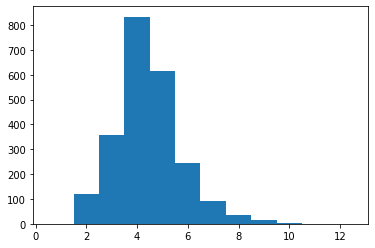

In [43]:
# View simulation result
simulation1_df = pd.DataFrame({'Victory': sim1_victory_list,
                              'Attempt Used': sim1_attempt_used_list})

simulation1_df.head()

print('Simulation using IG Score')
print('Win Rate:', round(sum(simulation1_df['Victory']) / simulation1_df.shape[0] * 100, 4), '%')
print('Attempt Used Average:', round(sum(simulation1_df['Attempt Used']) / sum(simulation1_df['Victory']), 4))
print()

# Print count of how many attempts were used to solve the game; 0 means it failed (didn't find the answer within 6 attempts)
attempt_count = simulation1_df.value_counts(subset=['Attempt Used'], sort=False)
print(attempt_count)
print()

# Plot histogram showing the counts
pyplot.hist(simulation1_df['Attempt Used'], bins=np.arange(0.5, 13, 1))

# Show which words were lost
print("Lost Count:", len(sim1_lost_list))
print("Lost Words:", sim1_lost_list)

### IG * ML Score

In [40]:
# Run bigger simulation using IG * ML Score
sim2_victory_list = []
sim2_attempt_used_list = []
sim2_lost_list = []

for answer in tqdm(real_list):
    victory, attempt_used = wordle_simulation(answer, max_try=99, scoring='Total Score', printout=False)
    sim2_victory_list.append(victory)
    sim2_attempt_used_list.append(attempt_used)

    # Note down the words that the solver failed on
    if attempt_used > 6:
        sim2_lost_list.append(answer)

100%|██████████| 2315/2315 [12:29<00:00,  3.09it/s]


Simulation using IG * ML Score
Win Rate: 97.9266 %
Attempt Used Average: 4.0459

Attempt Used
1                 1
2               120
3               706
4               864
5               453
6               123
7                33
8                12
9                 3
dtype: int64



Lost Count: 48
Lost Words: ['fuzzy', 'mammy', 'baste', 'batch', 'cinch', 'mucky', 'bound', 'bough', 'buggy', 'waver', 'catty', 'shave', 'gusty', 'gawky', 'hater', 'ferry', 'catch', 'fight', 'bitty', 'guppy', 'puppy', 'grown', 'hatch', 'fizzy', 'gummy', 'tatty', 'jaunt', 'daunt', 'goner', 'taffy', 'tripe', 'boxer', 'vaunt', 'jazzy', 'wight', 'golly', 'wound', 'saner', 'stave', 'foist', 'parry', 'creak', 'cower', 'sappy', 'boozy', 'stack', 'hitch', 'joker']


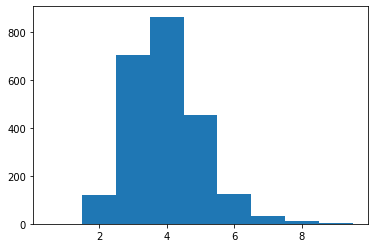

In [44]:
# View simulation result
simulation2_df = pd.DataFrame({'Victory': sim2_victory_list,
                              'Attempt Used': sim2_attempt_used_list})

print('Simulation using IG * ML Score')
print('Win Rate:', round(sum(simulation2_df['Victory']) / simulation2_df.shape[0] * 100, 4), '%')
print('Attempt Used Average:', round(sum(simulation2_df['Attempt Used']) / sum(simulation2_df['Victory']), 4))
print()

# Print count of how many attempts were used to solve the game; 0 means it failed (didn't find the answer within 6 attempts)
attempt_count = simulation2_df.value_counts(subset=['Attempt Used'], sort=False)
print(attempt_count)
print()
print()
print()

# Plot histogram showing the counts
pyplot.hist(simulation2_df['Attempt Used'], bins=np.arange(0.5, 10, 1))

# Show which words were lost
print("Lost Count:", len(sim2_lost_list))
print("Lost Words:", sim2_lost_list)

After running simulations, we see on average the Wordle Solver can guess the right answer using a little over 4, this is good.

However it failes to solve the game sometimes. This is troubling.

# To Do

- Usability: if there's one result, tell user it's the only answer
- Usability: if there is 0 result (meaning there is a mistake), go back to last step
- Performance: Try to implement code that prevents guess from being cornered
- Performance: Try finding more features to improve Machine Learning score (for example, vulgar swear words are probably not answers, or brand names with almost no meaning)
- Performance: Try different scoring methods, perhaps the weight of IG and ML scores would change based on current attempt number
